In [24]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union
import os

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# utilities
import time
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, plot_partials,
                        palette, colors, cmap)
from utils.utils_model import Network, visualize_layers, train
from utils.utils_plot import plotly_surface, plot_orbitals, get_middle_feats

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

### Data provenance
We train our model using the database of Density Functional Perturbation Theory (DFPT)-calculated phonon densities of states (DoS), containing approximately 1,500 crystalline solids [[Petretto et al. 2018]](https://doi.org/10.1038/sdata.2018.65).

In [25]:
# load data
df, species = load_data(os.path.join('data', 'data.csv'))
df.head()

100%|██████████| 1522/1522 [00:00<00:00, 35917.13it/s]


,mp_id,structure,phfreq,phdos,pdos,formula,species
0,mp-1000,"(Atom('Ba', [0.0, 0.0, 0.0], index=0), Atom('T...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.1603814665137704, 0.366293016390463, 0...","{'Ba': [0.0, 0.17004785173719497, 0.4321591874...",BaTe,"[Ba, Te]"
1,mp-1002124,"(Atom('Hf', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.02337731725373556, 0.030910686260937723, 0....","{'Hf': [0.026541048236378005, 0.03587084551615...",CHf,"[C, Hf]"
2,mp-1002164,"(Atom('Ge', [0.0, 0.0, 0.0], index=0), Atom('C...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0017221473876927959, 0.005981246148731...","{'Ge': [0.0, 0.00316167053214679, 0.0109190651...",CGe,"[C, Ge]"
3,mp-10044,"(Atom('B', [4.440892098500626e-16, 6.194849927...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.002277293012378372, 0.0078646582782471...","{'B': [0.0, 0.00029269193672558846, 0.00105324...",AsB,"[As, B]"
4,mp-1008223,"(Atom('Ca', [0.0, 0.0, 0.0], index=0), Atom('S...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.258870972416879, 0.5505201512544314, 0...","{'Ca': [0.0, 0.11150000312651394, 0.2215562000...",CaSe,"[Se, Ca]"


### Data structures
Crystal structures are represented as [ASE](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#the-atoms-object) (Atomic Simulation Environment) `Atoms` objects, which store the atomic species and positions of each atom in the unit cell, as well as the lattice vectors of the unit cell.

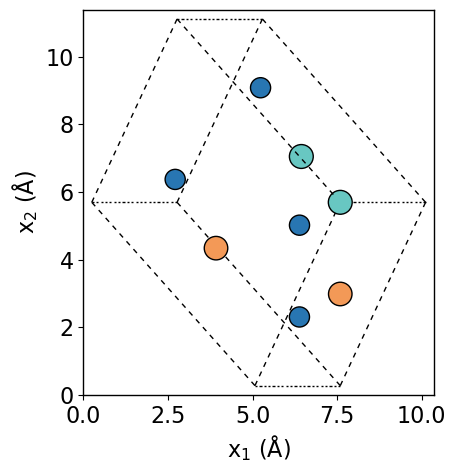

In [26]:
# plot an example structure
i = 12  # structure index in dataframe

struct = df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6, 5))
norm = plt.Normalize(vmin=0, vmax=len(symbols) - 1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('0x,90y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$');

average lattice parameter (a/b/c): 4.913216585660792 / 5.258921900844212 / 6.5187904554067595


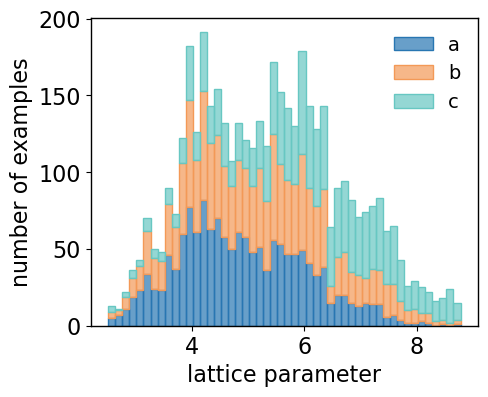

In [27]:
# lattice parameter statistics
def get_lattice_parameters(df):
    a = []
    for entry in df.itertuples():
        a.append(entry.structure.cell.cellpar()[:3])
    return np.stack(a)


a = get_lattice_parameters(df)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:, 0], a[:, 1], a[:, 2]]):
    color = [int(c.lstrip('#')[i:i + 2], 16) / 255. for i in (0, 2, 4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color + [0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('lattice parameter')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average lattice parameter (a/b/c):', a[:, 0].mean(), '/', a[:, 1].mean(), '/', a[:, 2].mean())

### Feature representation
We construct the inputs to our neural network following the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/guide/periodic_boundary_conditions.html) on handling point inputs with periodic boundary conditions. For a given crystal, each atom in the unit cell is associated with a feature vector that one-hot encodes its atomic mass in the index corresponding to its atomic number. The unit cell of the crystal is encoded as a graph in which two atoms (nodes) are joined by an edge if they are within a cutoff radius `r_max` of one another.

In [28]:
# one-hot encoding atom type and mass
type_encoding = {}
specie_am = []
for Z in tqdm(range(1, 119), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    specie_am.append(specie.mass)

type_onehot = torch.eye(len(type_encoding))
am_onehot = torch.diag(torch.tensor(specie_am))

100%|██████████| 118/118 [00:00<00:00, 103346.81it/s]


In [29]:
# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)

    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)

    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x=am_onehot[[type_encoding[specie] for specie in symbols]],  # atomic mass (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]],  # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        phdos=torch.from_numpy(entry.phdos).unsqueeze(0)
    )

    return data


r_max = 4.  # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1522/1522 [00:09<00:00, 161.70it/s]


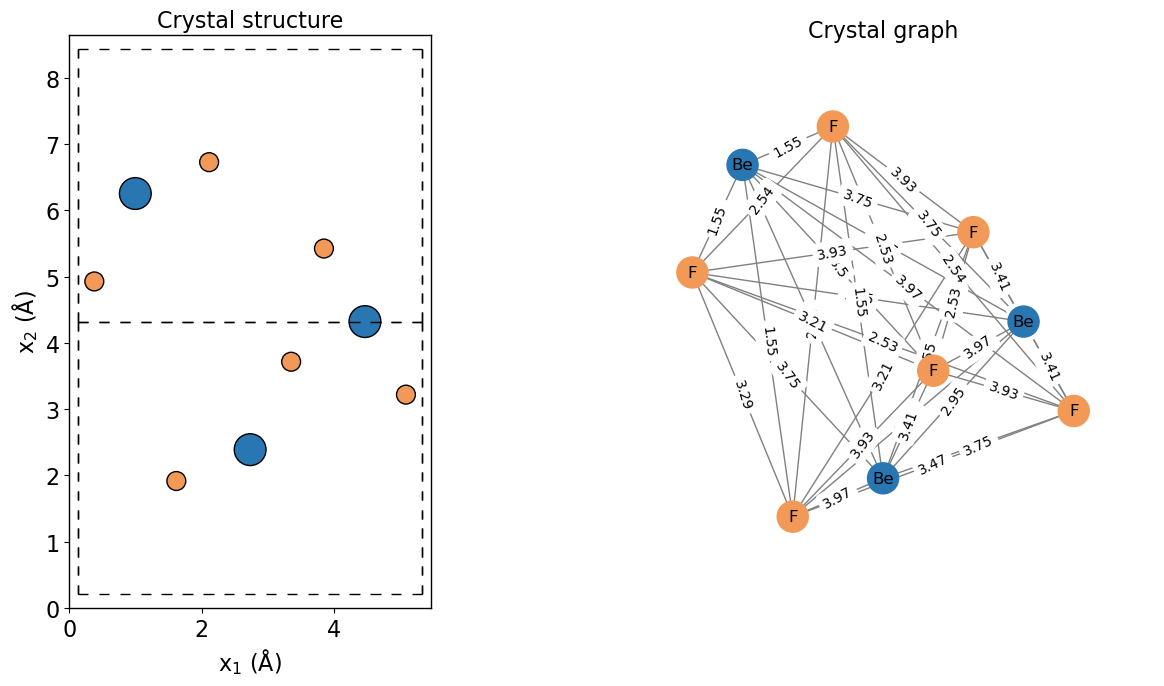

In [30]:
i = 244  # structure index in dataframe
plot_example(df, i=i, label_edges=True)

### Training, validation, and testing datasets
Split the data into training, validation, and testing datasets with balanced representation of different elements in each set.

split train/dev ...


100%|██████████| 64/64 [00:00<00:00, 208.33it/s]


split valid/test ...


100%|██████████| 62/62 [00:00<00:00, 360.90it/s]


number of training examples: 1192
number of validation examples: 141
number of testing examples: 189
total number of examples: 1522


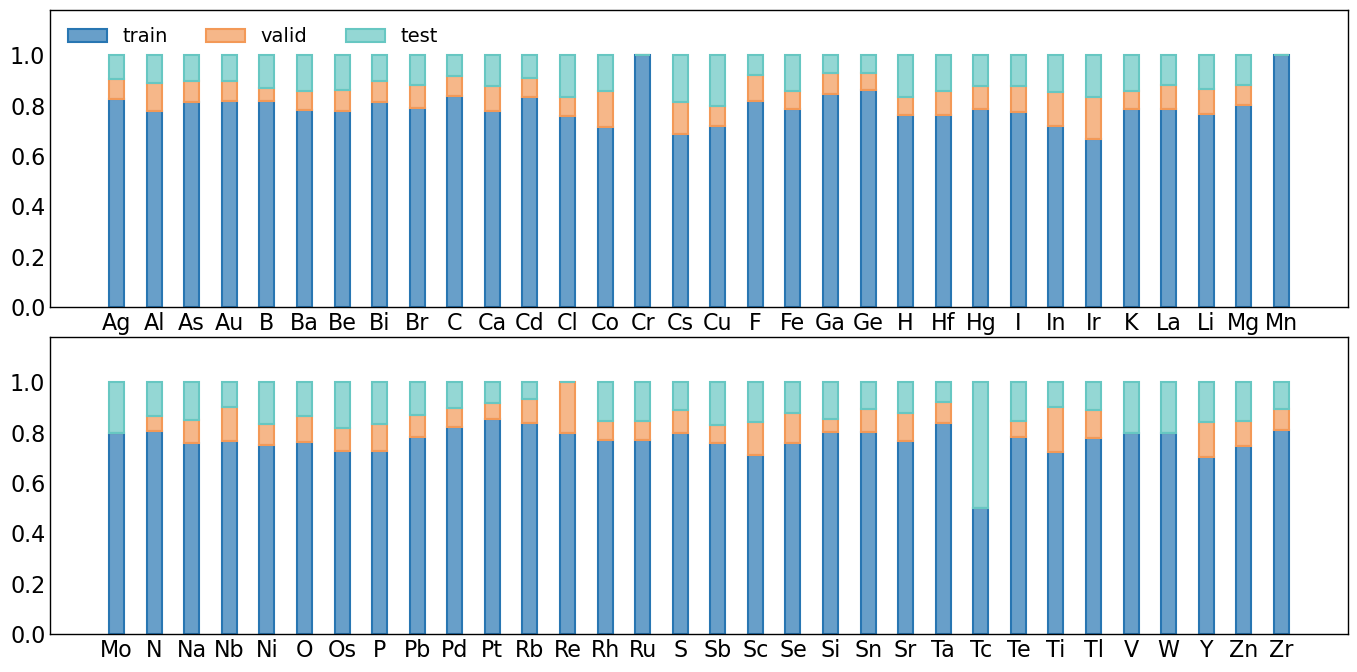

In [31]:
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, seed=12, plot=True)

For use with the trained model provided, the indices of the training, validation, and test sets are loaded below. These indices were generated with a specific seed using the above `train_valid_test_split` function.

In [32]:
# load train/valid/test indices
with open(os.path.join('data', 'idx_train.txt'), 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open(os.path.join('data', 'idx_valid.txt'), 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open(os.path.join('data', 'idx_test.txt'), 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

average number of neighbors (train/valid/test): 15.837087001257574 / 15.272818455366098 / 15.455339153794492


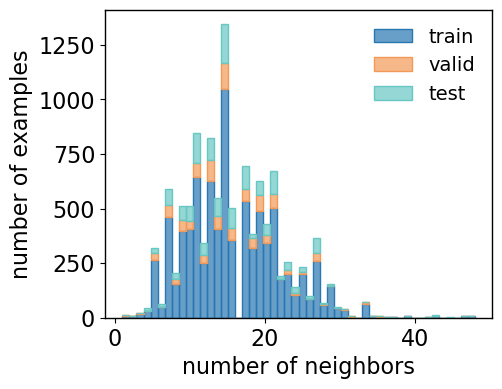

In [33]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)


n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i + 2], 16) / 255. for i in (0, 2, 4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color + [0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('number of neighbors')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

### Network architecture
We build a model based on the `Network` described in the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/api/nn/models/gate_points_2101.html), modified to incorporate the periodic boundaries we imposed on the crystal graphs. The network applies equivariant convolutions to each atomic node and finally takes an average over all nodes, normalizing the output.

In [34]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True

        super().__init__(**kwargs)

        # embed the mass-weighted one-hot encoding
        self.em = nn.Linear(in_dim, em_dim)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.x = F.relu(self.em(data.x))
        data.z = F.relu(self.em(data.z))
        output = super().forward(data)
        output = torch.relu(output)

        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example

        maxima, _ = torch.max(output, dim=1)
        output = output.div(maxima.unsqueeze(1))

        return output

In [35]:
out_dim = len(df.iloc[0]['phfreq'])
em_dim = 64

model = PeriodicNetwork(
    in_dim=118,  # dimension of one-hot encoding of atom type
    em_dim=em_dim,  # dimension of atom-type embedding
    irreps_in=str(em_dim) + "x0e",  # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim) + "x0e",  # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim) + "x0e",  # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,  # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,  # multiplicity of irreducible representations
    lmax=1,  # maximum order of spherical harmonics
    max_radius=r_max,  # cutoff radius for convolution
    num_neighbors=n_train.mean(),  # scaling factor based on the typical number of neighbors
    reduce_output=True  # whether or not to aggregate features of all atoms at the end
)

print(model)

C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3\lib\site-packages\torch\jit\_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e+32x1o | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 128]
        (tp): TensorProduct(64x0e x 1x0e+1x1o -> 64x0e+64x1o | 128 paths | 128 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o x 64x0e -> 64x0e+32x1o | 393216 paths | 393216 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 96x0e+32x1o+32x1e | 262144 paths | 262144 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o x 64x0e -> 32x0e+32x1o | 131072 paths | 131072 weights)
        (fc): FullyConnectedNet[10, 100, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+

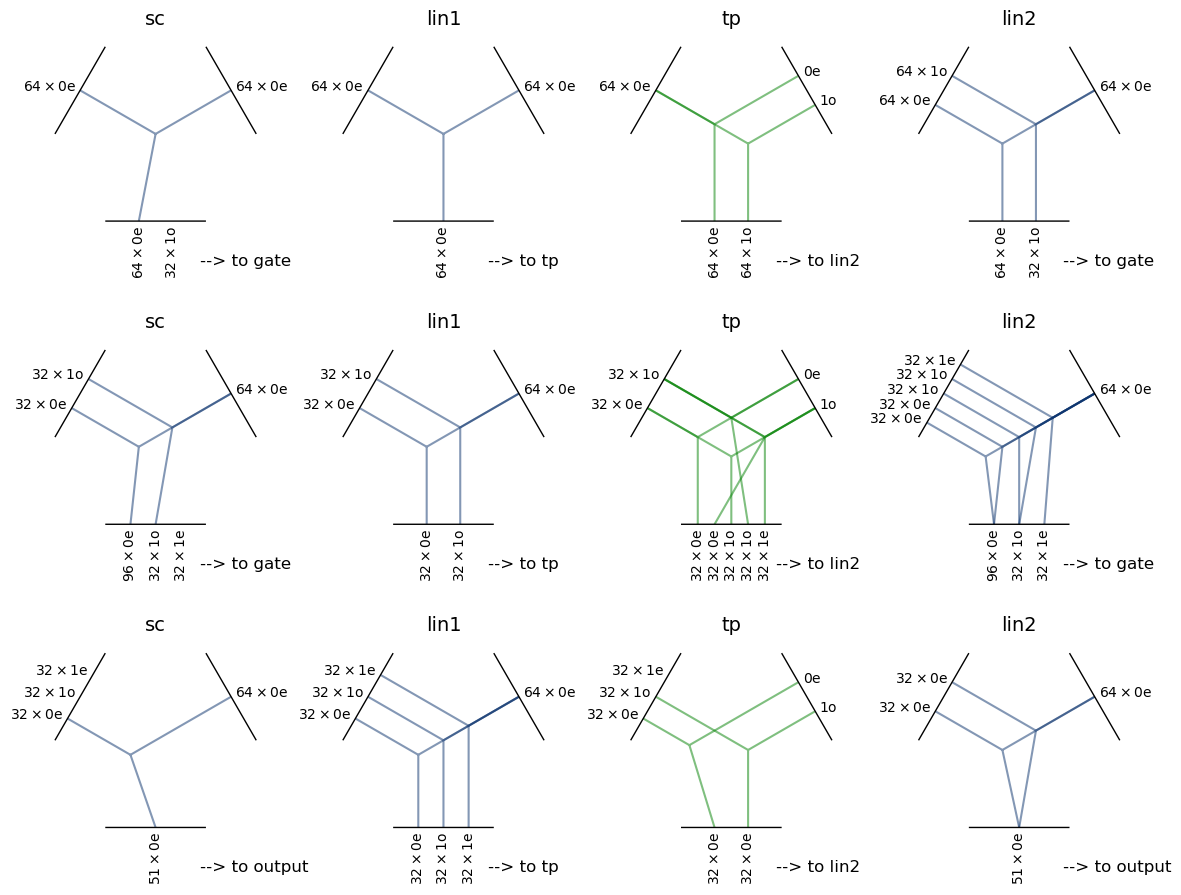

In [36]:
# visualize tensor products of the model
visualize_layers(model)

### Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [37]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [38]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:', device)

run_name = 'model_' + time.strftime("%y%m%d", time.localtime())
print(run_name)

torch device: cpu
model_240214


In [39]:
model.pool = True
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
      max_iter=1, scheduler=scheduler, device=device)

 22%|██▏       | 267/1192 [01:25<04:56,  3.12it/s]


KeyboardInterrupt: 

In [ ]:
dataloader_train.dataset[0]

In [ ]:
zzz = df.iloc[0]

In [ ]:
# load pre-trained model and plot its training history
run_name = 'model'

history = torch.load(run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(steps, loss_train, 'o-', label="Training", color=colors['train'])
ax.plot(steps, loss_valid, 'o-', label="Validation", color=colors['valid'])
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend(frameon=False);

### Results
We evaluate our model by visualizing the predicted and true DoS in each error quartile. We further compare the hidden features learned for each node to the partial DoS.

In [ ]:
# predict on all data
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)

df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

In [ ]:
plot_predictions(df, idx_train, 'Training')

In [ ]:
plot_predictions(df, idx_valid, 'Validation')

In [ ]:
plot_predictions(df, idx_test, 'Testing')

In [ ]:
# compare to partial DoS
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = False

# plot example predicted and true partial dos
plot_partials(model, df, idx_train, device=device)

### Alloys
The current framework extends easily to the representation of alloy structures. As an example, we will predict the phonon DoS of the Mg<sub>3</sub>(Bi,Sb)<sub>2</sub> system, incrementally varying the relative fractions of Bi and Sb. Note that both parent compounds, Mg<sub>3</sub>Sb<sub>2</sub> and Mg<sub>3</sub>Bi<sub>2</sub>, are present in our training data. We will check the validity by comparing the predicted and calculated phonon DoS of Mg<sub>3</sub>Bi<sub>1.5</sub>Sb<sub>0.5</sub>.

In [ ]:
# load calculated alloy example
df_alloy, _ = load_data('data/data_alloy.csv')
df_alloy.head()

In [ ]:
# get indices of parent structures
idx_Mg3Sb2 = df.loc[df['mp_id'] == 'mp-2646'].index.to_numpy()[0]
idx_Mg3Bi2 = df.loc[df['mp_id'] == 'mp-569018'].index.to_numpy()[0]
print(f'index of Mg3Sb2: {idx_Mg3Sb2}', f'\nindex of Mg3Bi2: {idx_Mg3Bi2}')

In [ ]:
# interpolate atomic positions and lattice constants
# 2-hot encode the atomic mass, weighted by the fraction of each species
data_alloy = []
x_Bi = np.linspace(0.01, 0.99, 99)

for i, p in tqdm(enumerate(x_Bi), total=len(x_Bi), bar_format=bar_format):
    symbols = df['data'][idx_Mg3Bi2].symbol.copy()
    positions = torch.lerp(df['data'][idx_Mg3Sb2].pos.clone(), df['data'][idx_Mg3Bi2].pos.clone(), p)
    lattice = torch.lerp(df['data'][idx_Mg3Sb2].lattice.clone(), df['data'][idx_Mg3Bi2].lattice.clone(), p)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    struct = df.iloc[idx_Mg3Bi2].structure.copy()
    struct.positions = positions.numpy().copy()
    struct.cell = lattice.numpy().squeeze().copy()
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=struct, cutoff=r_max, self_interaction=True)

    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)

    data_alloy.append(
        tg.data.Data(
            pos=positions,
            lattice=lattice,
            symbol=symbols,
            x=torch.lerp(df['data'][idx_Mg3Sb2].x, df['data'][idx_Mg3Bi2].x, p),
            z=torch.lerp(df['data'][idx_Mg3Sb2].z, df['data'][idx_Mg3Bi2].z, p),
            edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
            edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
            edge_vec=edge_vec, edge_len=edge_len,
            phdos=df['data'][idx_Mg3Bi2].phdos.clone()
        )
    )

In [ ]:
# predict on all alloy structures
model.load_state_dict(torch.load(run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader([df.iloc[idx_Mg3Sb2]['data']] + data_alloy + [df.iloc[idx_Mg3Bi2]['data']],
                                  batch_size=32)

output = np.zeros((len(data_alloy) + 2, len(df_alloy['phdos'][0])))
model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output[i0:i0 + len(d.phdos), :] = model(d).cpu().numpy()
        i0 += len(d.phdos)

In [ ]:
# plot predictions, and compare with calculated result for selected compound
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 2]})
color = cmap(np.linspace(0, 1, len(output)))
f = df_alloy['phfreq'][0]

# waterfall plot of alloy predictions
s = 2. / len(x_Bi)
for i in range(len(output)):
    ax1.plot(f, output[i] / output[i].max() + i * s, c=color[i])
ax1.set_yticklabels([])
ax1.set_xlabel('$Frequency\ (cm^{-1})$')
ax1.set_ylabel('$Intensity$')

sm = mpl.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cax = inset_axes(ax1, width="40%", height="4%", loc=3, bbox_to_anchor=(0.5, 0.9, 1, 1), bbox_transform=ax1.transAxes)
cbar = fig.colorbar(sm, cax=cax, aspect=16, orientation='horizontal', pad=-0.1)
cbar.ax.set_xlabel('$x_{Bi}$', fontsize=16, labelpad=-5)

# comparison to calculation
p = x_Bi.tolist().index(0.75)
ax2.remove()
ax2 = fig.add_subplot(122, projection='3d')

# plot calculations
ax2.plot(f, [0.75] * len(f), df_alloy['phdos'][0], lw=1.5, c='black', label='Calculated')
ax2.plot(f, [0] * len(f), df.iloc[idx_Mg3Sb2]['phdos'], lw=1.5, c='black')
ax2.plot(f, [1] * len(f), df.iloc[idx_Mg3Bi2]['phdos'], lw=1.5, c='black')

# plot predictions
ax2.plot(f, [0.75] * len(f), output[p] / output[p].max(), lw=2, c=palette[1], label='Predicted (alloy)')
ax2.plot(f, [0] * len(f), output[0] / output[0].max(), lw=2, c=palette[0], label='Predicted (pure)')
ax2.plot(f, [1] * len(f), output[-1] / output[-1].max(), lw=2, c=palette[0])

ax2.view_init(elev=20, azim=-50)
ax2.w_xaxis.set_pane_color((1., 1., 1., 1.))
ax2.w_yaxis.set_pane_color((1., 1., 1., 1.))
ax2.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.))
ax2.grid(False)
ax2.w_xaxis.line.set_color('dimgray');
ax2.w_yaxis.line.set_color('dimgray');
ax2.w_zaxis.line.set_color('dimgray')

ax2.set_xlabel('$Frequency\ (cm^{-1})$', labelpad=14)
ax2.set_ylabel('$x_{Bi}$', labelpad=10)
ax2.set_zlabel('$Intensity$', labelpad=10)
ax2.legend(frameon=False, bbox_to_anchor=(0.9, 0.4), bbox_transform=fig.transFigure);

### Visualization of intermediate features
We can visualize the intermediate features on each node projected onto the basis of spherical harmonics.

In [ ]:
d = next(iter(dataloader_train))
specie = d.symbol[0]
sts, st_feats = get_middle_feats(d, model, normalize=True)

for sts_idx in range(len(sts)):
    traces, traces_species = plotly_surface(sts[sts_idx], st_feats[sts_idx].detach().cpu(), centers=d.pos.cpu(),
                                            res=20, radius=True, species=specie)
    fig_html = plot_orbitals(traces, traces_species, title_str=f'feature: {str(sts[sts_idx])}')

    with open(f'feature_{str(sts[sts_idx])}.html', 'w') as f:
        f.write(fig_html)

#### For Colab only:

In [ ]:
from IPython.display import HTML

imgs = [f'feature_{str(sts[sts_idx])}.html' for sts_idx in range(len(sts))]

for img in imgs:
    display(HTML(filename=img))